NFL Spread Results for FanDuel (Latest Spreads Only)

Total Games Analyzed: 957

Results Breakdown:
away_covered: 501 games (52.35%)
home_covered: 439 games (45.87%)
push: 17 games (1.78%)


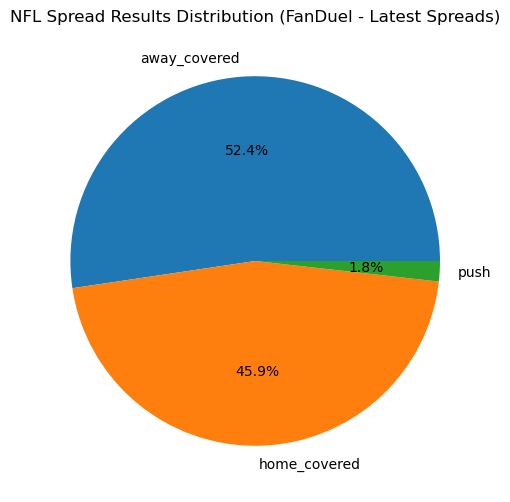

<Figure size 1200x600 with 0 Axes>

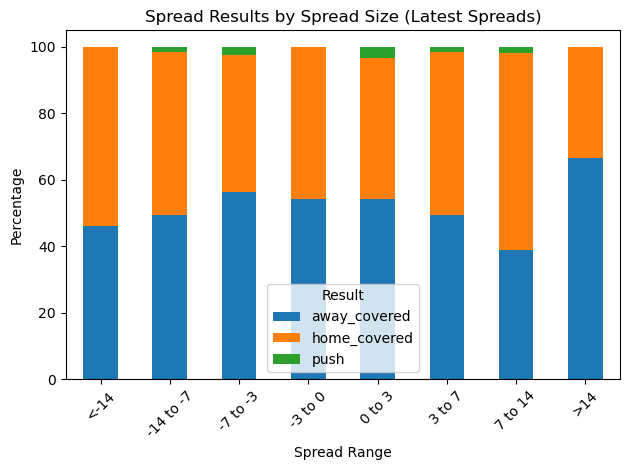


Spread Recording Timing:
Average hours before game: 102.8
Median hours before game: 41.0
Min hours before game: 20.1
Max hours before game: 5517.4


<Figure size 1200x600 with 0 Axes>

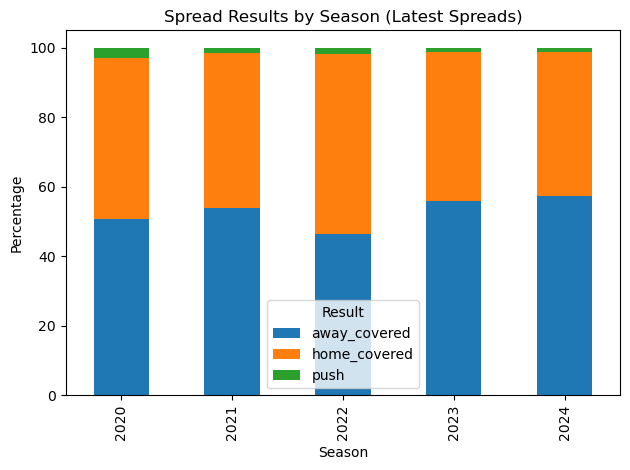


Performance When Team is Favorite:
result    away_covered  home_covered  push
favorite                                  
away             50.14         47.58  2.28
home             53.63         44.88  1.49

Spread Accuracy:
Average difference from spread: -0.71 points
Median difference from spread: -0.50 points
Standard deviation: 11.83 points


In [7]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore') 

# Connect to your database
conn = mysql.connector.connect(
    host="127.0.0.1",
    port="3307",
    user="root",
    database="odds_tracker"
)

# Query to get only the latest FanDuel spread for each game
query = """
WITH LatestSpreads AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    s.spread,
    sr.result,
    g.commence_time,
    ht.name as home_team,
    at.name as away_team,
    sc.home_score,
    sc.away_score,
    s.recorded_at as spread_recorded_at
FROM spread_results sr
JOIN spreads s ON sr.spread_id = s.id
JOIN LatestSpreads ls ON s.id = ls.spread_id
JOIN casinos c ON s.casino_id = c.id
JOIN games g ON s.game_id = g.id
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN scores sc ON sr.score_id = sc.id
JOIN sports sp ON g.sport_id = sp.id
WHERE c.name = 'FanDuel'
AND sp.key = 'americanfootball_nfl'
AND ls.rn = 1  -- Only get the latest spread
ORDER BY g.commence_time;
"""

# Load data into pandas
df = pd.read_sql(query, conn)

# Basic Calculations
total_games = len(df)
result_counts = df['result'].value_counts()
result_percentages = (result_counts / total_games * 100).round(2)

# Display overall results
print("NFL Spread Results for FanDuel (Latest Spreads Only)")
print("=" * 50)
print(f"\nTotal Games Analyzed: {total_games}")
print("\nResults Breakdown:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Plotting overall distribution
plt.figure(figsize=(10, 6))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('NFL Spread Results Distribution (FanDuel - Latest Spreads)')
plt.show()

# Analysis by spread size
df['spread_bucket'] = pd.cut(df['spread'], 
                           bins=[-21, -14, -7, -3, 0, 3, 7, 14, 21],
                           labels=['<-14', '-14 to -7', '-7 to -3', '-3 to 0', 
                                 '0 to 3', '3 to 7', '7 to 14', '>14'])

spread_analysis = pd.crosstab(df['spread_bucket'], df['result'], normalize='index') * 100

plt.figure(figsize=(12, 6))
spread_analysis.plot(kind='bar', stacked=True)
plt.title('Spread Results by Spread Size (Latest Spreads)')
plt.xlabel('Spread Range')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Time between spread recording and game
df['spread_recorded_at'] = pd.to_datetime(df['spread_recorded_at'])
df['commence_time'] = pd.to_datetime(df['commence_time'])
df['hours_before_game'] = (df['commence_time'] - df['spread_recorded_at']).dt.total_seconds() / 3600

print("\nSpread Recording Timing:")
print(f"Average hours before game: {df['hours_before_game'].mean():.1f}")
print(f"Median hours before game: {df['hours_before_game'].median():.1f}")
print(f"Min hours before game: {df['hours_before_game'].min():.1f}")
print(f"Max hours before game: {df['hours_before_game'].max():.1f}")

# Season by season analysis
df['season'] = pd.to_datetime(df['commence_time']).dt.year
season_analysis = pd.crosstab(df['season'], df['result'], normalize='index') * 100

plt.figure(figsize=(12, 6))
season_analysis.plot(kind='bar', stacked=True)
plt.title('Spread Results by Season (Latest Spreads)')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Home/Away favorite analysis
df['favorite'] = df['spread'].apply(lambda x: 'home' if x < 0 else 'away')
favorite_analysis = pd.crosstab([df['favorite']], df['result'], normalize='index') * 100

print("\nPerformance When Team is Favorite:")
print(favorite_analysis.round(2))

# Average margin vs spread
df['actual_margin'] = df['home_score'] - df['away_score']
df['spread_difference'] = df['actual_margin'] + df['spread']  # How far off the spread was

print("\nSpread Accuracy:")
print(f"Average difference from spread: {df['spread_difference'].mean():.2f} points")
print(f"Median difference from spread: {df['spread_difference'].median():.2f} points")
print(f"Standard deviation: {df['spread_difference'].std():.2f} points")

# Close connection
conn.close()

In [11]:
from scipy import stats
import numpy as np

# Total non-push games
total_decisions = 501 + 439  # Excluding pushes
away_wins = 501

# Perform binomial test
# H0: p = 0.5 (fair coin flip)
# H1: p ≠ 0.5 (biased towards away teams)
p_value = stats.binomtest(away_wins, total_decisions, p=0.5).pvalue

# Calculate confidence interval
confidence_interval = stats.binomtest(away_wins, total_decisions).proportion_ci()

# Calculate ROI assuming -110 odds
stake = 110
win_amount = 100
total_wagered = total_decisions * stake
wins_profit = away_wins * win_amount
losses_cost = (total_decisions - away_wins) * stake
roi = (wins_profit - losses_cost) / total_wagered * 100

print(f"Total Decisions (excluding pushes): {total_decisions}")
print(f"Away Cover Rate: {away_wins/total_decisions:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"95% Confidence Interval: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")
print(f"Expected ROI at -110 odds: {roi:.2f}%")

Total Decisions (excluding pushes): 940
Away Cover Rate: 0.5330
P-value: 0.0466
95% Confidence Interval: (0.5005, 0.5653)
Expected ROI at -110 odds: 1.75%


Analysis of Home Favorites (-7 to -3 points)

Total Games: 323

Results Breakdown:
away_covered: 178 games (55.11%)
home_covered: 137 games (42.41%)
push: 8 games (2.48%)


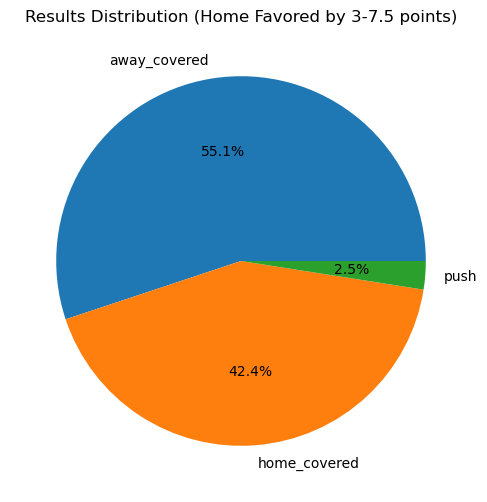


Spread Distribution:
Average spread: -4.9 points
Most common spread: -3.5 points

Actual Margin Analysis:
Average margin: 4.0 points
Median margin: 3.0 points
Standard deviation: 12.5 points


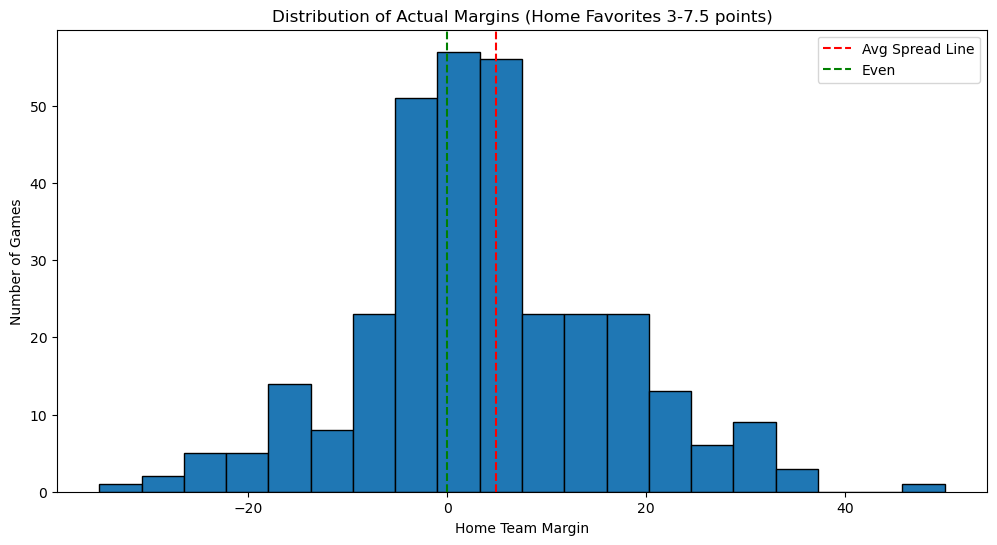


Season by Season Breakdown:
result  away_covered  home_covered  push
season                                  
2020           49.28         44.93  5.80
2021           62.50         37.50  0.00
2022           48.48         48.48  3.03
2023           55.56         41.98  2.47
2024           62.86         37.14  0.00


<Figure size 1200x600 with 0 Axes>

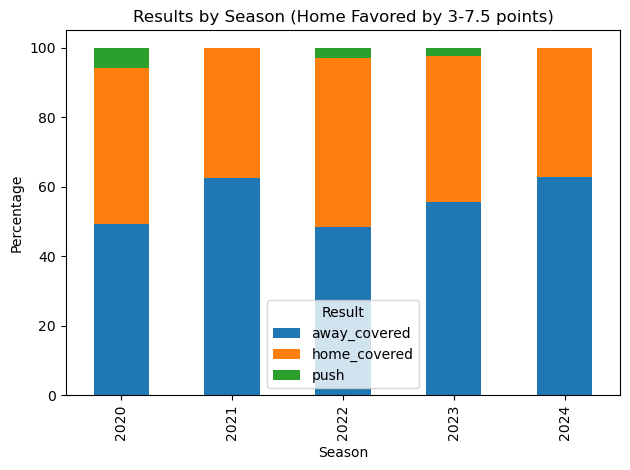

In [8]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

# Query focusing on home favorites (-7 to -3)
query = """
WITH LatestSpreads AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    s.spread,
    sr.result,
    g.commence_time,
    ht.name as home_team,
    at.name as away_team,
    sc.home_score,
    sc.away_score,
    s.recorded_at as spread_recorded_at,
    (sc.home_score - sc.away_score) as actual_margin
FROM spread_results sr
JOIN spreads s ON sr.spread_id = s.id
JOIN LatestSpreads ls ON s.id = ls.spread_id
JOIN casinos c ON s.casino_id = c.id
JOIN games g ON s.game_id = g.id
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN scores sc ON sr.score_id = sc.id
JOIN sports sp ON g.sport_id = sp.id
WHERE c.name = 'FanDuel'
AND sp.key = 'americanfootball_nfl'
AND ls.rn = 1  -- Only get the latest spread
AND s.spread BETWEEN -7.5 AND -3  -- Home team favored by 3-7 points
ORDER BY g.commence_time;
"""

# Load data
df = pd.read_sql(query, engine)

# Basic stats
total_games = len(df)
result_counts = df['result'].value_counts()
result_percentages = (result_counts / total_games * 100).round(2)

print(f"Analysis of Home Favorites (-7 to -3 points)")
print("=" * 50)
print(f"\nTotal Games: {total_games}")
print("\nResults Breakdown:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Visualization of results
plt.figure(figsize=(10, 6))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Results Distribution (Home Favored by 3-7.5 points)')
plt.show()

# Spread specific analysis
df['spread'] = df['spread'].abs()  # Convert to positive for easier reading
print("\nSpread Distribution:")
print(f"Average spread: -{df['spread'].mean():.1f} points")
print(f"Most common spread: -{df['spread'].mode().iloc[0]:.1f} points")

# Actual margin analysis
print("\nActual Margin Analysis:")
print(f"Average margin: {df['actual_margin'].mean():.1f} points")
print(f"Median margin: {df['actual_margin'].median():.1f} points")
print(f"Standard deviation: {df['actual_margin'].std():.1f} points")

# Visualize actual margins vs spreads
plt.figure(figsize=(12, 6))
plt.hist(df['actual_margin'], bins=20, edgecolor='black')
plt.axvline(x=df['spread'].mean(), color='r', linestyle='--', label='Avg Spread Line')
plt.axvline(x=0, color='g', linestyle='--', label='Even')
plt.title('Distribution of Actual Margins (Home Favorites 3-7.5 points)')
plt.xlabel('Home Team Margin')
plt.ylabel('Number of Games')
plt.legend()
plt.show()

# Season breakdown
df['season'] = pd.to_datetime(df['commence_time']).dt.year
season_analysis = pd.crosstab(df['season'], df['result'], normalize='index') * 100

print("\nSeason by Season Breakdown:")
print(season_analysis.round(2))

plt.figure(figsize=(12, 6))
season_analysis.plot(kind='bar', stacked=True)
plt.title('Results by Season (Home Favored by 3-7.5 points)')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Close connection
engine.dispose()

In [10]:
from scipy import stats
import numpy as np

# Total non-push games
total_decisions = 158 + 121  # Excluding pushes
away_wins = 158

# Perform binomial test
# H0: p = 0.5 (fair coin flip)
# H1: p ≠ 0.5 (biased towards away teams)
p_value = stats.binomtest(away_wins, total_decisions, p=0.5).pvalue

# Calculate confidence interval
confidence_interval = stats.binomtest(away_wins, total_decisions).proportion_ci()

# Calculate ROI assuming -110 odds
stake = 110
win_amount = 100
total_wagered = total_decisions * stake
wins_profit = away_wins * win_amount
losses_cost = (total_decisions - away_wins) * stake
roi = (wins_profit - losses_cost) / total_wagered * 100

print(f"Total Decisions (excluding pushes): {total_decisions}")
print(f"Away Cover Rate: {away_wins/total_decisions:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"95% Confidence Interval: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")
print(f"Expected ROI at -110 odds: {roi:.2f}%")

Total Decisions (excluding pushes): 279
Away Cover Rate: 0.5663
P-value: 0.0310
95% Confidence Interval: (0.5059, 0.6253)
Expected ROI at -110 odds: 8.11%


Line Movement Analysis (Increased Home Team Favoritism)

Total Games with Movement: 299
Average Movement: 4.3 points
Median Movement: 2.0 points
Largest Movement: 34.5 points

Results Breakdown:
away_covered: 155 games (51.84%)
home_covered: 141 games (47.16%)
push: 3 games (1.0%)

Results by Movement Size:
result           away_covered  home_covered  push
movement_bucket                                  
1 point                 48.00         50.67  1.33
1-2 points              48.89         50.00  1.11
2-3 points              55.81         41.86  2.33
3-4 points              73.33         26.67  0.00
4+ points               52.63         47.37  0.00


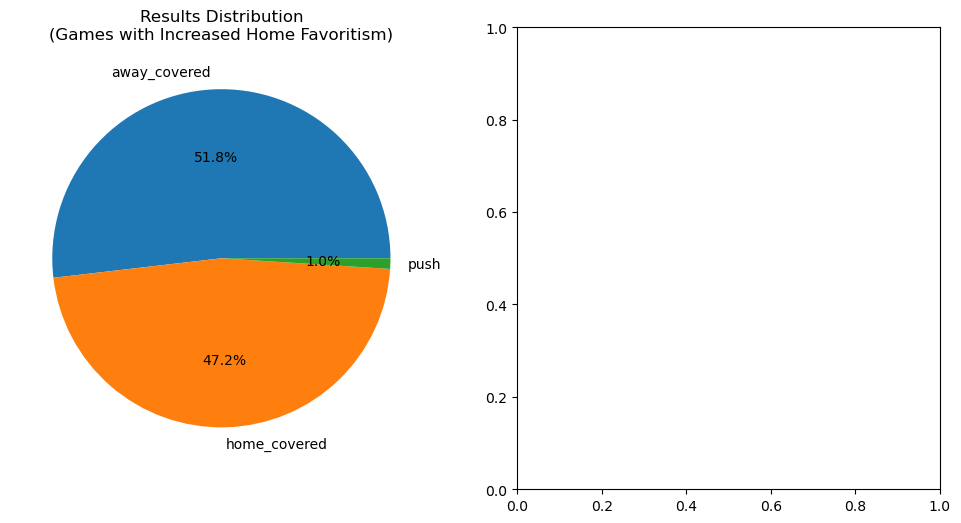

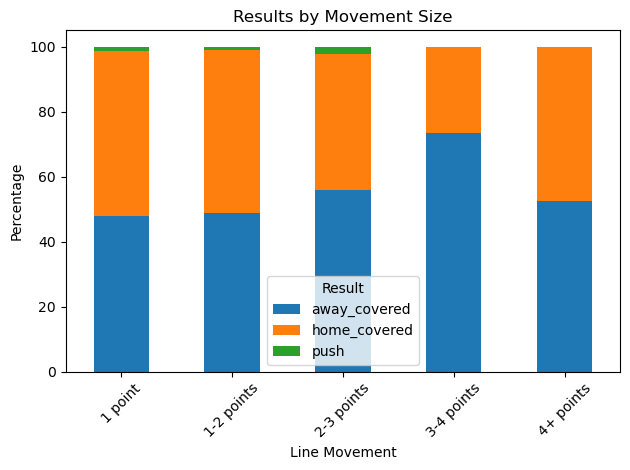


Largest Line Movements:
                    home_team                 away_team  opening_spread  closing_spread  spread_movement        result  home_score  away_score
224            Denver Broncos        Kansas City Chiefs             8.5             7.5             -1.0  away_covered          16          43
225          Seattle Seahawks           New York Giants            -9.5           -10.5             -1.0  away_covered          12          17
226          Seattle Seahawks      New England Patriots            -3.5            -4.5             -1.0  home_covered          35          30
227  Washington Football Team       Philadelphia Eagles             6.5             5.5             -1.0  home_covered          27          17
228          Cleveland Browns  Washington Football Team            -6.5            -7.5             -1.0  home_covered          34          20
229       San Francisco 49ers          Los Angeles Rams             3.5             2.5             -1.0  home_covere

In [16]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

# Query to find line movements favoring home team
query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    fs.opening_time,
    ls.closing_time,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND ls.closing_spread < fs.opening_spread  -- Line moved to favor home team more
HAVING spread_movement <= -1  -- At least 1 point movement
ORDER BY ABS(spread_movement) DESC;
"""

# Load data
df = pd.read_sql(query, engine)

# Add calculated fields
df['hours_between'] = (pd.to_datetime(df['closing_time']) - pd.to_datetime(df['opening_time'])).dt.total_seconds() / 3600

print("Line Movement Analysis (Increased Home Team Favoritism)")
print("=" * 60)
print(f"\nTotal Games with Movement: {len(df)}")
print(f"Average Movement: {abs(df['spread_movement']).mean():.1f} points")
print(f"Median Movement: {abs(df['spread_movement']).median():.1f} points")
print(f"Largest Movement: {abs(df['spread_movement']).max():.1f} points")

# Results analysis
result_counts = df['result'].value_counts()
result_percentages = (result_counts / len(df) * 100).round(2)

print("\nResults Breakdown:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Movement size buckets
df['movement_bucket'] = pd.cut(abs(df['spread_movement']), 
                             bins=[0, 1, 2, 3, 4, float('inf')],
                             labels=['1 point', '1-2 points', '2-3 points', '3-4 points', '4+ points'])

# Results by movement size
movement_analysis = pd.crosstab(df['movement_bucket'], df['result'], normalize='index') * 100

print("\nResults by Movement Size:")
print(movement_analysis.round(2))

# Visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Results Distribution\n(Games with Increased Home Favoritism)')

plt.subplot(1, 2, 2)
movement_analysis.plot(kind='bar', stacked=True)
plt.title('Results by Movement Size')
plt.xlabel('Line Movement')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Top movements
print("\nLargest Line Movements:")
columns = ['home_team', 'away_team', 'opening_spread', 'closing_spread', 
          'spread_movement', 'result', 'home_score', 'away_score']
print(df[columns].nlargest(10, 'spread_movement').to_string())

# Time analysis
print("\nTiming Analysis:")
print(f"Average hours between open and close: {df['hours_between'].mean():.1f}")
print(f"Median hours between open and close: {df['hours_between'].median():.1f}")

# Clean up
engine.dispose()

Line Movement Analysis (Moved TO Home -3 to -7.5)

Total Games with Movement: 323
Average Movement: 1.2 points
Median Movement: 0.5 points

Results Breakdown:
away_covered: 178 games (55.11%)
home_covered: 137 games (42.41%)
push: 8 games (2.48%)

Results by Starting Line Position:
result                    away_covered  home_covered  push
opening_category                                          
Home favored by more             48.57         45.71  5.71
Target Range                     55.00         43.33  1.67
Home favored by less/Dog         60.42         35.42  4.17


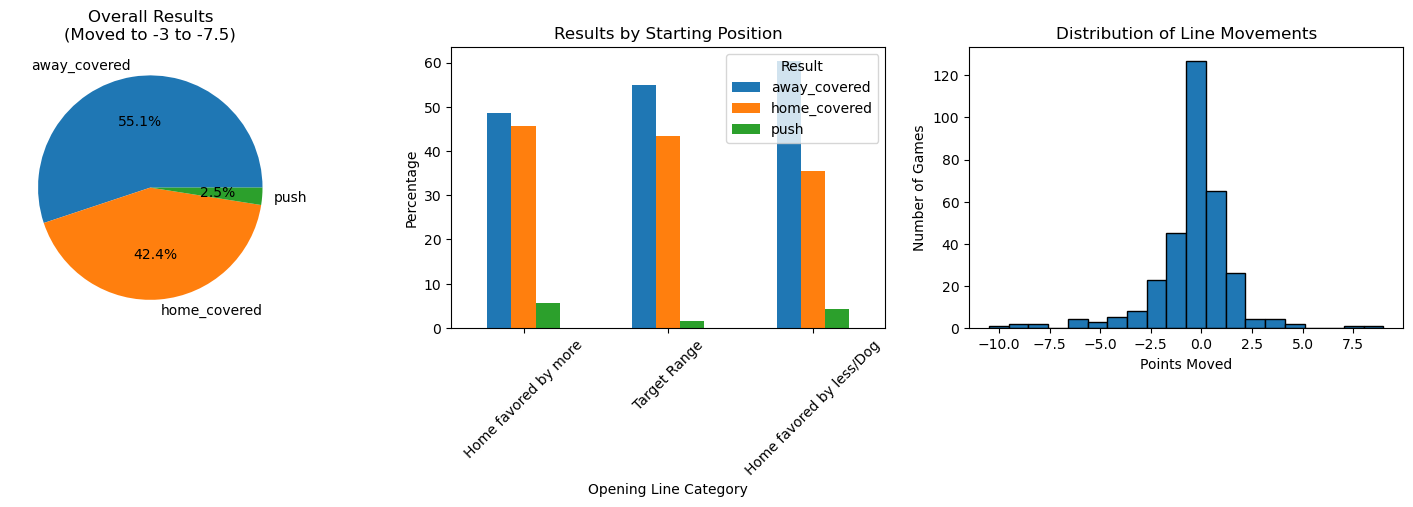


Example Movements:

Largest Movements:
             home_team             away_team  opening_spread  closing_spread  spread_movement        result  home_score  away_score
3        Buffalo Bills         New York Jets           -16.5            -7.5              9.0  home_covered          27          10
6   Indianapolis Colts  Jacksonville Jaguars           -14.0            -6.5              7.5  home_covered          28          14
14    Tennessee Titans        Houston Texans            -8.5            -3.5              5.0  away_covered          14          19
18  Cincinnati Bengals      Los Angeles Rams            -7.5            -3.0              4.5          push          19          16
21  Kansas City Chiefs  Jacksonville Jaguars            -8.5            -4.5              4.0  home_covered          27          20

Timing Analysis:
Average hours between open and close: 440.0
Median hours between open and close: 168.0

Results by Movement Direction:
result                     away

In [6]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    fs.opening_time,
    ls.closing_time,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND ls.closing_spread BETWEEN -7.5 AND -3  -- Final spread has home team favored by 3-7.5
ORDER BY ABS(spread_movement) DESC;
"""

# Load data
df = pd.read_sql(query, engine)

# Add calculated fields
df['hours_between'] = (pd.to_datetime(df['closing_time']) - pd.to_datetime(df['opening_time'])).dt.total_seconds() / 3600

print("Line Movement Analysis (Moved TO Home -3 to -7.5)")
print("=" * 60)
print(f"\nTotal Games with Movement: {len(df)}")
print(f"Average Movement: {abs(df['spread_movement']).mean():.1f} points")
print(f"Median Movement: {abs(df['spread_movement']).median():.1f} points")

# Categorize opening lines
df['opening_category'] = pd.cut(
    df['opening_spread'],
    bins=[-float('inf'), -7.5, -3, float('inf')],
    labels=['Home favored by more', 'Target Range', 'Home favored by less/Dog']
)

# Results analysis
result_counts = df['result'].value_counts()
result_percentages = (result_counts / len(df) * 100).round(2)

print("\nResults Breakdown:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Analysis by starting position
start_analysis = pd.crosstab(df['opening_category'], df['result'], normalize='index') * 100

print("\nResults by Starting Line Position:")
print(start_analysis.round(2))

# Visualizations
plt.figure(figsize=(15, 5))

# Overall results
plt.subplot(1, 3, 1)
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Overall Results\n(Moved to -3 to -7.5)')

# Results by starting position
plt.subplot(1, 3, 2)
start_analysis.plot(kind='bar', ax=plt.gca())
plt.title('Results by Starting Position')
plt.xlabel('Opening Line Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Result')

# Movement distribution
plt.subplot(1, 3, 3)
plt.hist(df['spread_movement'], bins=20, edgecolor='black')
plt.title('Distribution of Line Movements')
plt.xlabel('Points Moved')
plt.ylabel('Number of Games')

plt.tight_layout()
plt.show()

# Detailed movement examples
print("\nExample Movements:")
columns = ['home_team', 'away_team', 'opening_spread', 'closing_spread', 
          'spread_movement', 'result', 'home_score', 'away_score']
print("\nLargest Movements:")
print(df[columns].nlargest(5, 'spread_movement').to_string())

# Average timing of movements
print("\nTiming Analysis:")
print(f"Average hours between open and close: {df['hours_between'].mean():.1f}")
print(f"Median hours between open and close: {df['hours_between'].median():.1f}")

# Results by direction of movement
df['movement_direction'] = np.where(df['spread_movement'] < 0, 
                                  'Increased Home Favoritism', 
                                  'Decreased Home Favoritism')
direction_analysis = pd.crosstab(df['movement_direction'], df['result'], normalize='index') * 100

print("\nResults by Movement Direction:")
print(direction_analysis.round(2))

# Clean up
engine.dispose()

Examples of Increased Home Favoritism:

Top 5 Largest Movements Towards Home Favoritism:
             home_team             away_team  opening_spread  closing_spread  spread_movement        result  home_score  away_score
0       Denver Broncos  Los Angeles Chargers             3.0            -7.5            -10.5  away_covered          31          28
1    Arizona Cardinals      Seattle Seahawks             3.0            -6.5             -9.5  away_covered          20          21
2  San Francisco 49ers      Seattle Seahawks             5.5            -3.5             -9.0  away_covered          23          26
3       Dallas Cowboys   Philadelphia Eagles             1.5            -6.5             -8.0  home_covered          37          17
4     Seattle Seahawks   San Francisco 49ers             3.5            -4.5             -8.0  home_covered          30          23

Results Breakdown for Games with Increased Home Favoritism:
----------------------------------------------------------

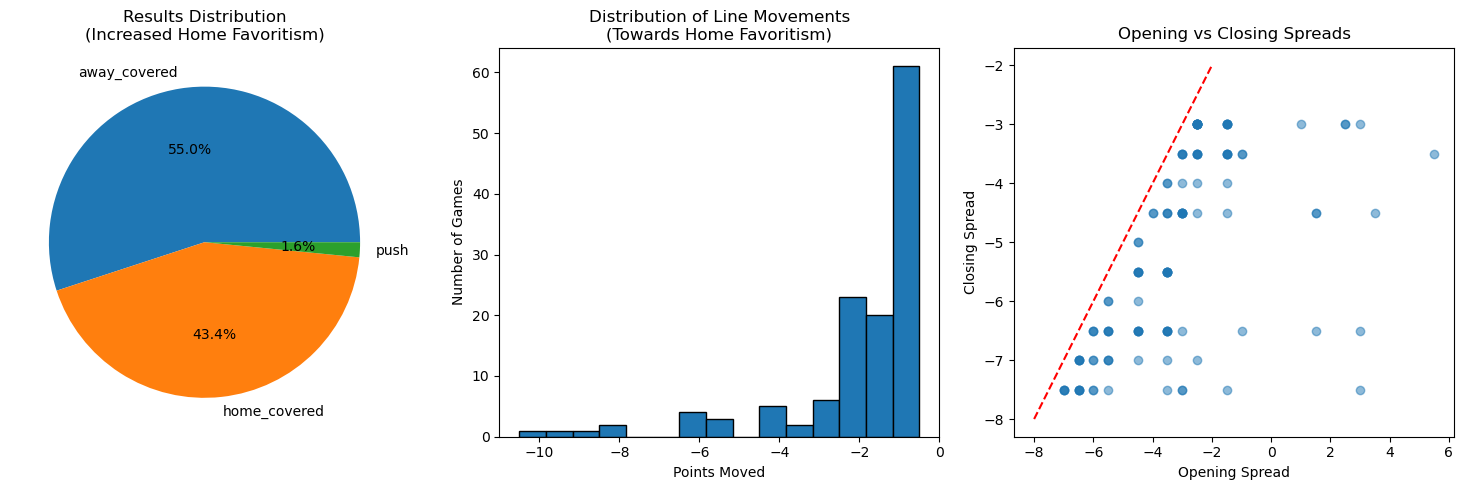


Timing Analysis:
Average hours between open and close: 378.4
Median hours between open and close: 168.0


In [10]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    fs.opening_time,
    ls.closing_time,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND ls.closing_spread BETWEEN -7.5 AND -3  -- Final spread has home team favored by 3-7.5
AND ls.closing_spread < fs.opening_spread   -- Line moves to more home favoritism
ORDER BY spread_movement ASC
"""

# Load data
df = pd.read_sql(query, engine)

print("Examples of Increased Home Favoritism:")
print("=" * 80)
print("\nTop 5 Largest Movements Towards Home Favoritism:")
columns = ['home_team', 'away_team', 'opening_spread', 'closing_spread', 
          'spread_movement', 'result', 'home_score', 'away_score']
print(df[columns].head().to_string())

# Results analysis
result_counts = df['result'].value_counts()
result_percentages = (result_counts / len(df) * 100).round(2)

print("\nResults Breakdown for Games with Increased Home Favoritism:")
print("-" * 60)
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Visualizations
plt.figure(figsize=(15, 5))

# Overall results pie chart
plt.subplot(1, 3, 1)
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Results Distribution\n(Increased Home Favoritism)')

# Movement distribution
plt.subplot(1, 3, 2)
plt.hist(df['spread_movement'], bins=15, edgecolor='black')
plt.title('Distribution of Line Movements\n(Towards Home Favoritism)')
plt.xlabel('Points Moved')
plt.ylabel('Number of Games')

# Scatter plot of opening vs closing spreads
plt.subplot(1, 3, 3)
plt.scatter(df['opening_spread'], df['closing_spread'], alpha=0.5)
plt.plot([-8, -2], [-8, -2], 'r--')  # diagonal line for reference
plt.title('Opening vs Closing Spreads')
plt.xlabel('Opening Spread')
plt.ylabel('Closing Spread')

plt.tight_layout()
plt.show()

# Average timing of movements
print("\nTiming Analysis:")
df['hours_between'] = (pd.to_datetime(df['closing_time']) - pd.to_datetime(df['opening_time'])).dt.total_seconds() / 3600
print(f"Average hours between open and close: {df['hours_between'].mean():.1f}")
print(f"Median hours between open and close: {df['hours_between'].median():.1f}")

# Clean up
engine.dispose()

In [15]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    fs.opening_time,
    ls.closing_time,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND ls.closing_spread BETWEEN -7.5 AND -3  -- Final spread range
ORDER BY ls.closing_spread
"""

# Load data
df = pd.read_sql(query, engine)

# Round closing spreads to nearest 0.5
df['closing_spread_bucket'] = (df['closing_spread'] * 2).round() / 2

# Categorize movement direction
df['movement_direction'] = np.where(df['spread_movement'] < 0, 
                                  'Towards Home (More Negative)',
                                  'Away from Home (Less Negative)')

print("Breakdown by Closing Spread and Movement Direction")
print("=" * 80)

# Group by rounded closing spread and movement direction
for spread in sorted(df['closing_spread_bucket'].unique()):
    spread_df = df[df['closing_spread_bucket'] == spread]
    
    print(f"\nClosing Spread: {spread}")
    print("-" * 40)
    
    for direction in ['Towards Home (More Negative)', 'Away from Home (Less Negative)']:
        direction_df = spread_df[spread_df['movement_direction'] == direction]
        
        if len(direction_df) > 0:
            print(f"\n{direction}:")
            print(f"Total Games: {len(direction_df)}")
            print(f"Average Movement: {abs(direction_df['spread_movement'].mean()):.2f} points")
            
            results = direction_df['result'].value_counts()
            for result, count in results.items():
                percentage = (count / len(direction_df)) * 100
                print(f"{result}: {count} ({percentage:.1f}%)")

print("\nOverall Summary")
print("=" * 80)

for direction in ['Towards Home (More Negative)', 'Away from Home (Less Negative)']:
    direction_df = df[df['movement_direction'] == direction]
    print(f"\n{direction}:")
    print(f"Total Games: {len(direction_df)}")
    print(f"Average Movement: {abs(direction_df['spread_movement'].mean()):.2f} points")
    
    results = direction_df['result'].value_counts()
    print("\nResults Breakdown:")
    for result, count in results.items():
        percentage = (count / len(direction_df)) * 100
        print(f"{result}: {count} ({percentage:.1f}%)")

print("\nExample Games for Each Direction:")
print("=" * 80)

columns = ['home_team', 'away_team', 'opening_spread', 'closing_spread', 
          'spread_movement', 'result', 'home_score', 'away_score']

for direction in ['Towards Home (More Negative)', 'Away from Home (Less Negative)']:
    print(f"\n{direction} Examples:")
    print("-" * 40)
    direction_df = df[df['movement_direction'] == direction]
    print(direction_df[columns].head().to_string())

# Clean up
engine.dispose()

Breakdown by Closing Spread and Movement Direction

Closing Spread: -7.5
----------------------------------------

Towards Home (More Negative):
Total Games: 17
Average Movement: 2.44 points
away_covered: 10 (58.8%)
home_covered: 7 (41.2%)

Away from Home (Less Negative):
Total Games: 19
Average Movement: 0.97 points
away_covered: 10 (52.6%)
home_covered: 9 (47.4%)

Closing Spread: -7.0
----------------------------------------

Towards Home (More Negative):
Total Games: 13
Average Movement: 1.50 points
home_covered: 7 (53.8%)
away_covered: 6 (46.2%)

Away from Home (Less Negative):
Total Games: 13
Average Movement: 0.42 points
home_covered: 6 (46.2%)
away_covered: 5 (38.5%)
push: 2 (15.4%)

Closing Spread: -6.5
----------------------------------------

Towards Home (More Negative):
Total Games: 21
Average Movement: 2.71 points
away_covered: 12 (57.1%)
home_covered: 9 (42.9%)

Away from Home (Less Negative):
Total Games: 21
Average Movement: 0.60 points
away_covered: 11 (52.4%)
home_cov

In [ ]:
Bet away teams between 3 to 7.5, bet on line movements of between 2 to 4 points.4

Analysis of Home Favorites (-3 to -7.5)

Total Games: 346

Overall Results:
away_covered: 194 games (56.1%)
home_covered: 145 games (41.9%)
push: 7 games (2.0%)

Results by Spread Point:

Spread -7.5:
away_covered: 16 games (51.6%)
home_covered: 12 games (38.7%)
push: 3 games (9.7%)

Spread -7.0:
away_covered: 15 games (45.5%)
home_covered: 17 games (51.5%)
push: 1 games (3.0%)

Spread -6.5:
away_covered: 29 games (64.4%)
home_covered: 16 games (35.6%)
push: 0 games (0.0%)

Spread -6.0:
away_covered: 10 games (52.6%)
home_covered: 9 games (47.4%)
push: 0 games (0.0%)

Spread -5.5:
away_covered: 17 games (47.2%)
home_covered: 19 games (52.8%)
push: 0 games (0.0%)

Spread -5.0:
away_covered: 3 games (75.0%)
home_covered: 1 games (25.0%)
push: 0 games (0.0%)

Spread -4.5:
away_covered: 24 games (58.5%)
home_covered: 16 games (39.0%)
push: 1 games (2.4%)

Spread -4.0:
away_covered: 6 games (46.2%)
home_covered: 7 games (53.8%)
push: 0 games (0.0%)

Spread -3.5:
away_covered: 45 games (61.6

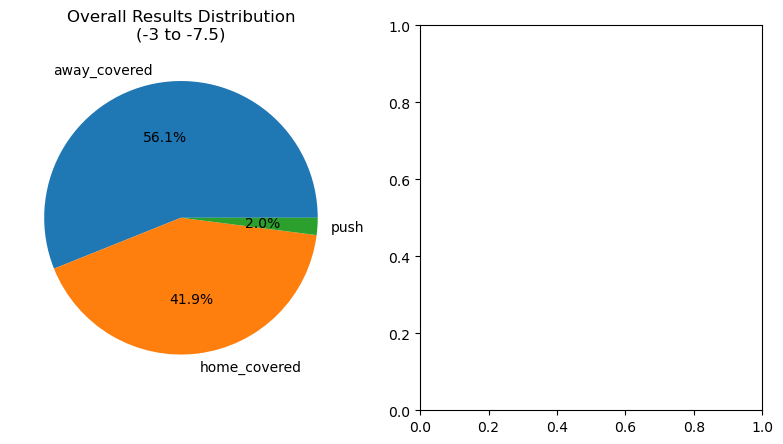

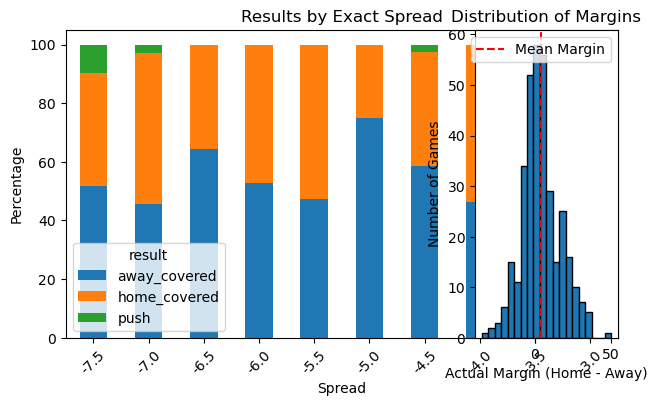


Overall Summary Statistics:
Average Margin: 4.0 points
Median Margin: 3.0 points
Standard Deviation: 12.6 points

Home Team Cover Rate: 41.9%


In [20]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND fs.opening_spread BETWEEN -7.5 AND -3
ORDER BY g.commence_time DESC;
"""

# Load data
df = pd.read_sql(query, engine)

print("Analysis of Home Favorites (-3 to -7.5)")
print("=" * 60)
print(f"\nTotal Games: {len(df)}")

# Overall results
result_counts = df['result'].value_counts()
result_percentages = (result_counts / len(df) * 100).round(1)

print("\nOverall Results:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Group by spread and result
spread_results = df.groupby(['opening_spread', 'result']).size().unstack(fill_value=0)
spread_percentages = spread_results.div(spread_results.sum(axis=1), axis=0) * 100

print("\nResults by Spread Point:")
for spread in sorted(df['opening_spread'].unique()):
    print(f"\nSpread {spread}:")
    total_games = len(df[df['opening_spread'] == spread])
    spread_data = spread_results.loc[spread]
    spread_pct = spread_percentages.loc[spread]
    
    for result in spread_data.index:
        count = int(spread_data[result])
        pct = round(spread_pct[result], 1)
        print(f"{result}: {count} games ({pct}%)")

# Calculate margins
df['margin'] = df['home_score'] - df['away_score']

# Margin analysis by spread
margin_analysis = df.groupby('opening_spread')['margin'].agg(['mean', 'std', 'count']).round(2)
print("\nMargin Analysis by Spread:")
print(margin_analysis)

# Visualization
plt.figure(figsize=(15, 5))

# Overall Results Pie Chart
plt.subplot(1, 3, 1)
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Overall Results Distribution\n(-3 to -7.5)')

# Results by Spread
plt.subplot(1, 3, 2)
spread_percentages.plot(kind='bar', stacked=True)
plt.title('Results by Exact Spread')
plt.xlabel('Spread')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

# Margin Distribution
plt.subplot(1, 3, 3)
plt.hist(df['margin'], bins=20, edgecolor='black')
plt.axvline(x=df['margin'].mean(), color='r', linestyle='--', label='Mean Margin')
plt.title('Distribution of Margins')
plt.xlabel('Actual Margin (Home - Away)')
plt.ylabel('Number of Games')
plt.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nOverall Summary Statistics:")
print(f"Average Margin: {df['margin'].mean():.1f} points")
print(f"Median Margin: {df['margin'].median():.1f} points")
print(f"Standard Deviation: {df['margin'].std():.1f} points")

# Overall home cover rate
cover_rate = (len(df[df['result'] == 'home_covered']) / len(df) * 100)
print(f"\nHome Team Cover Rate: {cover_rate:.1f}%")

# Clean up
engine.dispose()

Half-Point Spread Analysis

Overall Results (All Half-Point Spreads):
away_covered: 190 games (54.4%)
home_covered: 151 games (43.3%)
push: 8 games (2.3%)

Results by Favorite:

Home Favorite (226 games):
away_covered: 131 games (58.0%)
home_covered: 91 games (40.3%)
push: 4 games (1.8%)

Away Favorite (123 games):
home_covered: 60 games (48.8%)
away_covered: 59 games (48.0%)
push: 4 games (3.3%)

Individual Spread Analysis:

Spread -7.5 (31 games):
away_covered: 16 games (51.6%)
home_covered: 12 games (38.7%)
push: 3 games (9.7%)

Spread -6.5 (45 games):
away_covered: 29 games (64.4%)
home_covered: 16 games (35.6%)

Spread -5.5 (36 games):
home_covered: 19 games (52.8%)
away_covered: 17 games (47.2%)

Spread -4.5 (41 games):
away_covered: 24 games (58.5%)
home_covered: 16 games (39.0%)
push: 1 games (2.4%)

Spread -3.5 (73 games):
away_covered: 45 games (61.6%)
home_covered: 28 games (38.4%)

Spread 3.5 (39 games):
home_covered: 19 games (48.7%)
away_covered: 18 games (46.2%)
push: 2 

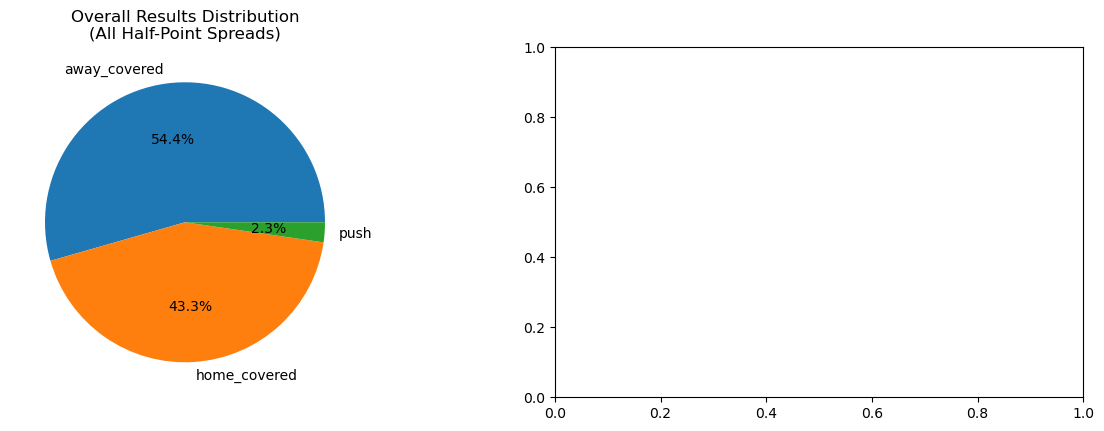

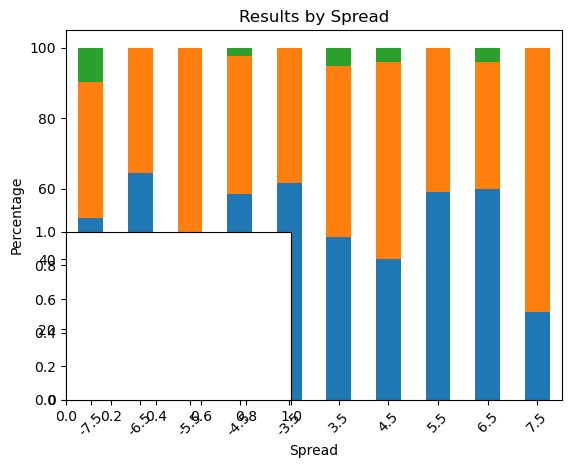

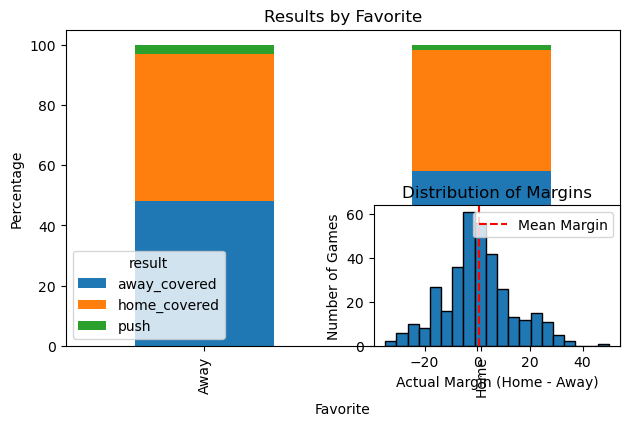


Margin Analysis by Spread:
                count   mean    std  median
opening_spread                             
-7.5               31   7.10  12.68     5.0
-6.5               45   3.82  12.53     3.0
-5.5               36   5.42  14.04     6.0
-4.5               41   2.29  14.14     3.0
-3.5               73   2.64  12.32     2.0
 3.5               39  -3.41  11.04    -3.0
 4.5               25   0.72  14.21    -3.0
 5.5               22 -10.45  11.19    -6.5
 6.5               25 -10.24  12.23   -14.0
 7.5               12  -5.25   6.81    -6.0

Season by Season Analysis:
result  away_covered  home_covered  push
season                                  
2020            49.4          47.1   3.5
2021            55.1          42.3   2.6
2022            50.7          49.3   0.0
2023            58.1          39.5   2.3
2024            63.6          33.3   3.0


In [21]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND (
    fs.opening_spread IN (-7.5, -6.5, -5.5, -4.5, -3.5) OR  -- Home favorites
    fs.opening_spread IN (3.5, 4.5, 5.5, 6.5, 7.5)          -- Away favorites
)
ORDER BY g.commence_time DESC;
"""

# Load data
df = pd.read_sql(query, engine)

# Add a column to identify favorite
df['favorite'] = np.where(df['opening_spread'] < 0, 'Home', 'Away')

print("Half-Point Spread Analysis")
print("=" * 60)

# Overall Analysis
print("\nOverall Results (All Half-Point Spreads):")
total_results = df['result'].value_counts()
total_percentages = (total_results / len(df) * 100).round(1)
for result, count in total_results.items():
    print(f"{result}: {count} games ({total_percentages[result]}%)")

# Analysis by Home/Away Favorite
print("\nResults by Favorite:")
for fav in ['Home', 'Away']:
    fav_df = df[df['favorite'] == fav]
    results = fav_df['result'].value_counts()
    percentages = (results / len(fav_df) * 100).round(1)
    print(f"\n{fav} Favorite ({len(fav_df)} games):")
    for result, count in results.items():
        print(f"{result}: {count} games ({percentages[result]}%)")

# Individual Spread Analysis
print("\nIndividual Spread Analysis:")
for spread in sorted(df['opening_spread'].unique()):
    spread_df = df[df['opening_spread'] == spread]
    results = spread_df['result'].value_counts()
    percentages = (results / len(spread_df) * 100).round(1)
    print(f"\nSpread {spread} ({len(spread_df)} games):")
    for result, count in results.items():
        print(f"{result}: {count} games ({percentages[result]}%)")

# Visualization
plt.figure(figsize=(15, 10))

# Overall Results
plt.subplot(2, 2, 1)
plt.pie(total_results, labels=total_results.index, autopct='%1.1f%%')
plt.title('Overall Results Distribution\n(All Half-Point Spreads)')

# Results by Spread
spread_results = df.pivot_table(
    index='opening_spread',
    columns='result',
    aggfunc='size',
    fill_value=0
)
spread_percentages = spread_results.div(spread_results.sum(axis=1), axis=0) * 100

plt.subplot(2, 2, 2)
spread_percentages.plot(kind='bar', stacked=True)
plt.title('Results by Spread')
plt.xlabel('Spread')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

# Home vs Away Favorite Comparison
plt.subplot(2, 2, 3)
favorite_results = df.pivot_table(
    index='favorite',
    columns='result',
    aggfunc='size',
    fill_value=0
)
favorite_percentages = favorite_results.div(favorite_results.sum(axis=1), axis=0) * 100
favorite_percentages.plot(kind='bar', stacked=True)
plt.title('Results by Favorite')
plt.xlabel('Favorite')
plt.ylabel('Percentage')

# Actual Margin Analysis
df['margin'] = df['home_score'] - df['away_score']
plt.subplot(2, 2, 4)
plt.hist(df['margin'], bins=20, edgecolor='black')
plt.axvline(x=df['margin'].mean(), color='r', linestyle='--', label='Mean Margin')
plt.title('Distribution of Margins')
plt.xlabel('Actual Margin (Home - Away)')
plt.ylabel('Number of Games')
plt.legend()

plt.tight_layout()
plt.show()

# Additional Analysis
print("\nMargin Analysis by Spread:")
margin_analysis = df.groupby('opening_spread')['margin'].agg([
    'count', 'mean', 'std', 'median'
]).round(2)
print(margin_analysis)

# ATS (Against The Spread) Record by Season
df['season'] = pd.to_datetime(df['commence_time']).dt.year
season_analysis = df.pivot_table(
    index='season',
    columns='result',
    aggfunc='size',
    fill_value=0
)
season_percentages = season_analysis.div(season_analysis.sum(axis=1), axis=0) * 100

print("\nSeason by Season Analysis:")
print(season_percentages.round(1))

# Clean up
engine.dispose()

Half-Point Spreads Analysis (-3.5 to -7.5)

Total Games: 226

Overall Results:
away_covered: 131 games (58.0%)
home_covered: 91 games (40.3%)
push: 4 games (1.8%)

Breakdown by Spread:

Spread -7.5 (31 games):
away_covered: 16 games (51.6%)
home_covered: 12 games (38.7%)
push: 3 games (9.7%)

Spread -6.5 (45 games):
away_covered: 29 games (64.4%)
home_covered: 16 games (35.6%)

Spread -5.5 (36 games):
home_covered: 19 games (52.8%)
away_covered: 17 games (47.2%)

Spread -4.5 (41 games):
away_covered: 24 games (58.5%)
home_covered: 16 games (39.0%)
push: 1 games (2.4%)

Spread -3.5 (73 games):
away_covered: 45 games (61.6%)
home_covered: 28 games (38.4%)


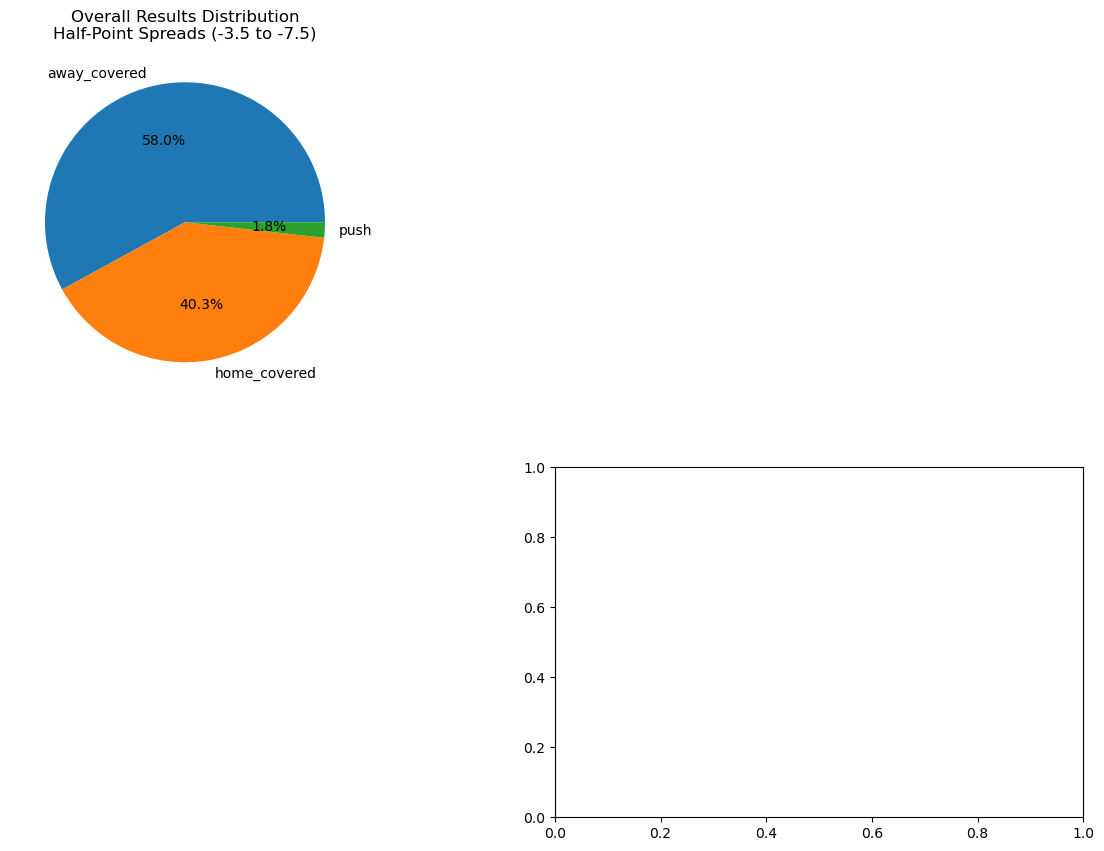

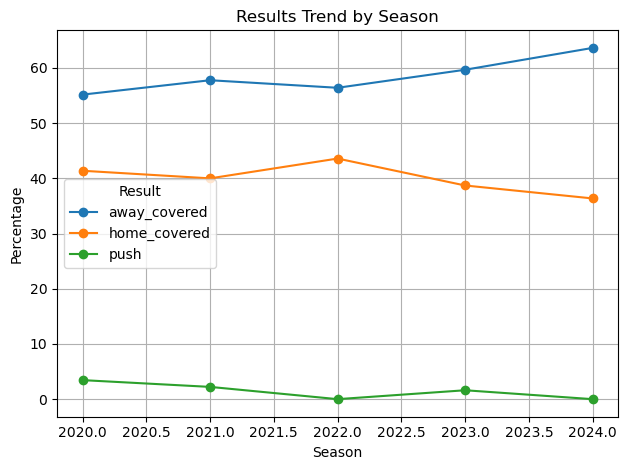


Margin Analysis:
Average Margin: 3.9 points
Median Margin: 3.0 points
Standard Deviation: 13.0 points

Season by Season Analysis:
result  away_covered  home_covered  push
season                                  
2020            55.2          41.4   3.4
2021            57.8          40.0   2.2
2022            56.4          43.6   0.0
2023            59.7          38.7   1.6
2024            63.6          36.4   0.0

Margin Analysis by Spread:
                count  mean    std  median
opening_spread                            
-7.5               31  7.10  12.68     5.0
-6.5               45  3.82  12.53     3.0
-5.5               36  5.42  14.04     6.0
-4.5               41  2.29  14.14     3.0
-3.5               73  2.64  12.32     2.0


In [25]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    sc.home_score,
    sc.away_score,
    sr.result,
    g.commence_time
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
JOIN scores sc ON sr.score_id = sc.id
WHERE sp.key = 'americanfootball_nfl'
AND fs.opening_spread IN (-7.5, -6.5, -5.5, -4.5, -3.5)  -- Half-point spreads between -3.5 and -7.5
ORDER BY g.commence_time DESC;
"""

# Load data
df = pd.read_sql(query, engine)

print("Half-Point Spreads Analysis (-3.5 to -7.5)")
print("=" * 60)
print(f"\nTotal Games: {len(df)}")

# Overall Results
result_counts = df['result'].value_counts()
result_percentages = (result_counts / len(df) * 100).round(1)

print("\nOverall Results:")
for result, count in result_counts.items():
    percentage = result_percentages[result]
    print(f"{result}: {count} games ({percentage}%)")

# Breakdown by specific spread
print("\nBreakdown by Spread:")
for spread in sorted(df['opening_spread'].unique()):
    subset = df[df['opening_spread'] == spread]
    total = len(subset)
    print(f"\nSpread {spread} ({total} games):")
    for result in subset['result'].value_counts().index:
        count = len(subset[subset['result'] == result])
        percentage = np.round((count/total * 100), 1)
        print(f"{result}: {count} games ({percentage}%)")

# Calculate margins
df['margin'] = df['home_score'] - df['away_score']
df['season'] = pd.to_datetime(df['commence_time']).dt.year

# Visualization
plt.figure(figsize=(15, 10))

# Overall Results Pie Chart
plt.subplot(2, 2, 1)
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%')
plt.title('Overall Results Distribution\nHalf-Point Spreads (-3.5 to -7.5)')

# Season Trends
season_results = pd.crosstab(df['season'], df['result'], normalize='index') * 100
plt.subplot(2, 2, 4)
season_results.plot(kind='line', marker='o')
plt.title('Results Trend by Season')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.legend(title='Result')
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional Analysis
print("\nMargin Analysis:")
print(f"Average Margin: {np.round(df['margin'].mean(), 1)} points")
print(f"Median Margin: {np.round(df['margin'].median(), 1)} points")
print(f"Standard Deviation: {np.round(df['margin'].std(), 1)} points")

# Season breakdown
print("\nSeason by Season Analysis:")
season_analysis = pd.crosstab(df['season'], df['result'], normalize='index') * 100
print(np.round(season_analysis, 1))

# Margin analysis by spread
print("\nMargin Analysis by Spread:")
margin_analysis = df.groupby('opening_spread')['margin'].agg([
    'count',
    'mean',
    'std',
    'median'
]).round(2)
print(margin_analysis)

# ROI Analysis (assuming -110 odds as standard)
df['roi'] = np.where(df['result'] == 'home_covered', 
                     100/110 * 100,
                     np.where(df['result'] == 'away_covered', -100, 0))

# Clean up
engine.dispose()

In [40]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_nfl'
AND (ls.closing_spread - fs.opening_spread) BETWEEN -4 AND -2  -- Line moves 2-4 points towards home team
"""

# Load data
df = pd.read_sql(query, engine)

# Calculate cover percentage
total_games = len(df)
home_covers = len(df[df['result'] == 'home_covered'])
away_covers = len(df[df['result'] == 'away_covered'])
pushes = len(df[df['result'] == 'wash'])

# Remove pushes from the total for percentage calculation
games_without_pushes = total_games - pushes
home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)

print("\nAnalysis of Lines Moving 2-4 Points Towards Home Team:")
print("=" * 60)
print(f"Total Games: {total_games}")
print(f"Home Team Covers: {home_covers}")
print(f"Away Team Covers: {away_covers}")
print(f"Pushes: {pushes}")
print(f"Home Cover Percentage (excluding pushes): {home_cover_percentage}%")
print(f"Away Cover Percentage (excluding pushes): {away_cover_percentage}%")

# Show some examples
print("\nExample Games (first 10):")
print(df[['home_team', 'away_team', 'opening_spread', 'closing_spread', 'spread_movement', 'result']].head(10))

# Clean up
engine.dispose()


Analysis of Lines Moving 2-4 Points Towards Home Team:
Total Games: 125
Home Team Covers: 57
Away Team Covers: 67
Pushes: 0
Home Cover Percentage (excluding pushes): 45.6%
Away Cover Percentage (excluding pushes): 53.6%

Example Games (first 10):
             home_team             away_team  opening_spread  closing_spread  \
0     Los Angeles Rams        Dallas Cowboys             2.5            -1.5   
1        New York Jets        Denver Broncos             2.5            -1.0   
2        Chicago Bears  Tampa Bay Buccaneers             5.5             3.5   
3  Philadelphia Eagles    New Orleans Saints             7.0             2.5   
4     Cleveland Browns    Indianapolis Colts             1.0            -1.0   
5   Indianapolis Colts         New York Jets            -8.5           -11.5   
6        Detroit Lions    New Orleans Saints             5.5             3.0   
7  San Francisco 49ers   Philadelphia Eagles            -6.5            -8.5   
8       Dallas Cowboys     Arizo

In [41]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_nfl'
AND (ls.closing_spread - fs.opening_spread) BETWEEN 2 AND 4  -- Line moves 2-4 points towards away team
"""

# Load data
df = pd.read_sql(query, engine)

# Calculate cover percentage
total_games = len(df)
home_covers = len(df[df['result'] == 'home_covered'])
away_covers = len(df[df['result'] == 'away_covered'])
pushes = len(df[df['result'] == 'wash'])

# Remove pushes from the total for percentage calculation
games_without_pushes = total_games - pushes
home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)

print("\nAnalysis of Lines Moving 2-4 Points Towards Away Team:")
print("=" * 60)
print(f"Total Games: {total_games}")
print(f"Home Team Covers: {home_covers}")
print(f"Away Team Covers: {away_covers}")
print(f"Pushes: {pushes}")
print(f"Home Cover Percentage (excluding pushes): {home_cover_percentage}%")
print(f"Away Cover Percentage (excluding pushes): {away_cover_percentage}%")

# Show some examples
print("\nExample Games (first 10):")
print(df[['home_team', 'away_team', 'opening_spread', 'closing_spread', 'spread_movement', 'result']].head(10))

# Clean up
engine.dispose()


Analysis of Lines Moving 2-4 Points Towards Away Team:
Total Games: 91
Home Team Covers: 42
Away Team Covers: 48
Pushes: 0
Home Cover Percentage (excluding pushes): 46.15%
Away Cover Percentage (excluding pushes): 52.75%

Example Games (first 10):
             home_team             away_team  opening_spread  closing_spread  \
0  San Francisco 49ers     Arizona Cardinals            -8.5            -6.5   
1  Philadelphia Eagles      Los Angeles Rams            -3.5            -1.5   
2  Philadelphia Eagles    Cincinnati Bengals            -6.0            -4.0   
3  Philadelphia Eagles       New York Giants            -6.5            -4.5   
4      New York Giants  Tampa Bay Buccaneers            10.5            12.5   
5  Pittsburgh Steelers    Indianapolis Colts            -3.0            -1.0   
6       Dallas Cowboys       Atlanta Falcons            -7.0            -3.5   
7       Miami Dolphins         Buffalo Bills             3.5             5.5   
8     Tennessee Titans  Jackson

In [45]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_nfl'
AND (
    -- When home is favorite (negative spread) and line moves more negative
    (fs.opening_spread < 0 AND ls.closing_spread < fs.opening_spread 
     AND (ls.closing_spread - fs.opening_spread) BETWEEN -4 AND -2)
    OR
    -- When away is favorite (positive spread) and line moves more positive
    (fs.opening_spread > 0 AND ls.closing_spread > fs.opening_spread 
     AND (ls.closing_spread - fs.opening_spread) BETWEEN 2 AND 4)
)
"""

# Load data
df = pd.read_sql(query, engine)

# Calculate cover percentage
total_games = len(df)
home_covers = len(df[df['result'] == 'home_covered'])
away_covers = len(df[df['result'] == 'away_covered'])
pushes = len(df[df['result'] == 'wash'])

# Remove pushes from the total for percentage calculation
games_without_pushes = total_games - pushes
home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)

print("\nAnalysis of Lines Moving 2-4 Points Towards Favorite:")
print("=" * 60)
print(f"Total Games: {total_games}")
print(f"Home Team Covers: {home_covers}")
print(f"Away Team Covers: {away_covers}")
print(f"Pushes: {pushes}")
print(f"Home Cover Percentage (excluding pushes): {home_cover_percentage}%")
print(f"Away Cover Percentage (excluding pushes): {away_cover_percentage}%")

# Show some examples
print("\nExample Games (first 10):")
pd.set_option('display.max_columns', None)
print(df[['home_team', 'away_team', 'opening_spread', 'closing_spread', 'spread_movement', 'result']].head(10))

# Clean up
engine.dispose()


Analysis of Lines Moving 2-4 Points Towards Favorite:
Total Games: 228
Home Team Covers: 104
Away Team Covers: 121
Pushes: 0
Home Cover Percentage (excluding pushes): 45.61%
Away Cover Percentage (excluding pushes): 53.07%

Example Games (first 10):
              home_team             away_team  opening_spread  closing_spread  \
0  Jacksonville Jaguars    Indianapolis Colts             7.0             8.0   
1   Pittsburgh Steelers        Denver Broncos            -5.5            -7.0   
2         New York Jets   San Francisco 49ers             5.5             7.0   
3       New York Giants  Tampa Bay Buccaneers            10.5            12.5   
4      Seattle Seahawks       New York Giants            -9.5           -10.5   
5   Philadelphia Eagles      Seattle Seahawks             5.0             6.5   
6        Miami Dolphins         Buffalo Bills             3.5             5.5   
7        Houston Texans      Baltimore Ravens             5.0             7.5   
8  Los Angeles Charg

In [2]:
from sqlalchemy import create_engine
import pandas as pd

# Create SQLAlchemy engine
engine = create_engine('mysql+pymysql://root@127.0.0.1:3307/odds_tracker')

query = """
WITH FirstSpread AS (
    SELECT 
        s.game_id,
        s.spread as opening_spread,
        s.recorded_at as opening_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at ASC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
),
LastSpread AS (
    SELECT 
        s.id as spread_id,
        s.game_id,
        s.spread as closing_spread,
        s.recorded_at as closing_time,
        ROW_NUMBER() OVER (PARTITION BY s.game_id ORDER BY s.recorded_at DESC) as rn
    FROM spreads s
    JOIN casinos c ON s.casino_id = c.id
    WHERE c.name = 'FanDuel'
)
SELECT 
    g.id as game_id,
    ht.name as home_team,
    at.name as away_team,
    fs.opening_spread,
    ls.closing_spread,
    (ls.closing_spread - fs.opening_spread) as spread_movement,
    sr.result
FROM games g
JOIN FirstSpread fs ON g.id = fs.game_id AND fs.rn = 1
JOIN LastSpread ls ON g.id = ls.game_id AND ls.rn = 1
JOIN teams ht ON g.home_team_id = ht.id
JOIN teams at ON g.away_team_id = at.id
JOIN sports sp ON g.sport_id = sp.id
JOIN spread_results sr ON sr.spread_id = ls.spread_id
WHERE sp.key = 'americanfootball_nfl'
AND fs.opening_spread < 0  -- Home team is favorite (negative spread)
AND ls.closing_spread < fs.opening_spread  -- Line moves more negative
AND (ls.closing_spread - fs.opening_spread) BETWEEN -4 AND -2  -- Movement between 2-4 points
"""

# Load data
df = pd.read_sql(query, engine)

# Calculate cover percentage
total_games = len(df)
home_covers = len(df[df['result'] == 'home_covered'])
away_covers = len(df[df['result'] == 'away_covered'])
pushes = len(df[df['result'] == 'wash'])

# Remove pushes from the total for percentage calculation
games_without_pushes = total_games - pushes
home_cover_percentage = round((home_covers / games_without_pushes * 100), 2)
away_cover_percentage = round((away_covers / games_without_pushes * 100), 2)

print("\nAnalysis of Home Favorites When Line Moves 2-4 Points More Negative:")
print("=" * 70)
print(f"Total Games: {total_games}")
print(f"Home Team (Favorite) Covers: {home_covers}")
print(f"Away Team (Underdog) Covers: {away_covers}")
print(f"Pushes: {pushes}")
print(f"Home Favorite Cover Percentage (excluding pushes): {home_cover_percentage}%")
print(f"Away Underdog Cover Percentage (excluding pushes): {away_cover_percentage}%")

# Show some examples
print("\nExample Games (first 10):")
pd.set_option('display.max_columns', None)
print(df[['home_team', 'away_team', 'opening_spread', 'closing_spread', 
          'spread_movement', 'result']].head(10))

# Clean up
engine.dispose()


Analysis of Home Favorites When Line Moves 2-4 Points More Negative:
Total Games: 74
Home Team (Favorite) Covers: 31
Away Team (Underdog) Covers: 42
Pushes: 0
Home Favorite Cover Percentage (excluding pushes): 41.89%
Away Underdog Cover Percentage (excluding pushes): 56.76%

Example Games (first 10):
             home_team                 away_team  opening_spread  \
0  Philadelphia Eagles            Dallas Cowboys            -7.5   
1  Philadelphia Eagles  Washington Football Team            -5.5   
2  Philadelphia Eagles  Washington Football Team            -7.5   
3  Philadelphia Eagles        Kansas City Chiefs            -1.5   
4  Philadelphia Eagles         Arizona Cardinals            -9.5   
5  Philadelphia Eagles           Atlanta Falcons            -3.5   
6  Philadelphia Eagles          Cleveland Browns            -6.5   
7        Buffalo Bills         Carolina Panthers           -10.5   
8        Buffalo Bills         Green Bay Packers            -8.5   
9        Buffalo 